###  Anomaly Detection on ECG data
###  author: L. Saetta
###  last update: 03/10/2020
#### Using **AutoEncoders**, dataset: ECG5000

#### work inspired by F. Chollet blog post, 
https://blog.keras.io/building-autoencoders-in-keras.html

#### and keras.io example
https://keras.io/examples/timeseries/timeseries_anomaly_detection/

#### Dataset from site:
http://www.timeseriesclassification.com/Downloads/ECG5000.zip

##### see also
http://www.timeseriesclassification.com/description.php?Dataset=ECG5000

#### Theory on AutoEncoders? the nice "Goodfellow" book
http://www.deeplearningbook.org/contents/autoencoders.html

We use an AutoEncoder to identify anomalies in electrocardiograms (ECG’s). 

The dataset “ECG5000” contains 5000 ECG, obtained from Physionet site under the name “BIDMC Congestive Heart Failure Database(chfdb), chf07”.

https://physionet.org/content/chfdb/1.0.0/#files-panel

Data has been pre-processed in 2 steps: each heartbeat is extracted, and then each beat is made equal length (140 points) via interpolation. 

The data is labeled in five classes. The first class which contains around 60% of the observations is seen as “normal” while the others are "anomalous"

In [1]:
# nice thing is that you don't require GPUs for training. It can be easily reproduced on a modern laptop (better Mac)

# tested with TF 2.3, but should work also with TF 2.2

In [2]:
import pandas as pd
import numpy as np

# using Seaborne for hist
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

from numpy.random import seed

sns.set(color_codes=True)
%matplotlib inline

# code for Tensorflow 2 !!!
print(tf.__version__)
assert(tf.__version__ >= '2.')

2.3.1


In [3]:
# training set

FILE_NAME = "ECG5000_TRAIN_NEW.txt"

data = pd.read_csv(FILE_NAME, delim_whitespace = True, header=None, engine = 'python')

# convert labels to integer
data[0] = data[0].astype('int32')

In [4]:
# I have decided to use ECG5000_TEST file for training and ECG5000_TRAIN as test set
# since TEST contains 4500 rows, TRAIN only 500, so it is better this way

In [5]:
# give human friendly names to columns
columns = ['label']

for i in range(1, 141):
    columns.append('P' + str(i))

In [6]:
# every sample is a ECG fragment, a Time Series with 140 points (columns from P1 to P140)
data.columns = columns
data.head(10)

,label,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P131,P132,P133,P134,P135,P136,P137,P138,P139,P140
0,1,3.690844,0.711414,-2.114092,-4.141007,-4.574472,-3.431909,-1.950791,-1.107067,-0.632322,...,-0.032477,0.022847,0.188937,0.480932,0.629250,0.577291,0.665527,1.035997,1.492287,-1.905073
1,1,-1.348132,-3.996038,-4.226750,-4.251187,-3.477953,-2.228422,-1.808488,-1.534242,-0.779861,...,0.937984,1.570938,1.591394,1.549193,1.193077,0.515134,0.126274,0.267532,1.071148,-1.164009
2,1,1.024295,-0.590314,-1.916949,-2.806989,-3.527905,-3.638675,-2.779767,-2.019031,-1.980754,...,0.368820,0.443502,0.827582,1.237007,1.235121,1.738103,1.800767,1.816301,1.473963,1.389767
3,1,0.545657,-1.014383,-2.316698,-3.634040,-4.196857,-3.758093,-3.194444,-2.221764,-1.588554,...,0.894638,0.777530,1.119240,0.902984,0.554098,0.497053,0.418116,0.703108,1.064602,-0.044853
4,1,0.661133,-1.552471,-3.124641,-4.313351,-4.017042,-3.005993,-1.832411,-1.503886,-1.071705,...,1.416582,1.280823,1.494316,1.618764,1.447449,1.238577,1.749692,1.986803,1.422756,-0.357784
5,1,1.649272,1.121169,-0.628753,-1.939899,-3.439175,-4.010776,-3.238067,-2.127737,-1.798465,...,0.229317,0.636727,1.166689,1.062871,1.628234,2.175072,2.500749,2.092176,1.455313,2.124303
6,1,-0.323103,-1.510804,-2.768216,-3.788649,-4.100396,-3.516576,-2.940032,-1.828790,-1.089045,...,1.421767,1.052238,0.213416,-1.003917,-1.676931,-2.055868,-1.968963,-1.548612,-1.411230,-2.620855
7,1,-1.309274,-4.045362,-4.757328,-4.657040,-3.634479,-2.469447,-1.640088,-1.408992,-0.706937,...,0.651832,1.371353,1.257078,1.246964,1.156629,0.311326,-0.325923,-0.385273,0.385835,-0.393619
8,1,-1.736906,-3.647089,-4.005470,-4.413745,-4.082557,-3.234594,-1.935797,-1.367653,-1.055027,...,1.085795,1.130086,1.317606,1.181094,0.976701,0.541003,0.288060,0.479704,0.658353,-0.326727
9,1,-1.101873,-1.965967,-2.399643,-2.905194,-3.107600,-3.041231,-2.105358,-1.621213,-1.589307,...,1.390032,1.436628,0.931638,0.332091,0.409455,0.489593,0.890026,1.026954,0.937848,0.321598


In [7]:
# how many samples?
len(data)

4500

In [8]:
# prepare the data for plotting
data_vec = data.to_numpy()

In [9]:
# function to plot a single ECG fragment
def plot_ecg(vec, index):
    '''
    vec is the entire set of data
    index identify the fragment to visualize
    '''
    label = vec[index, 0]
    
    vet = vec[index, 1:]
    time = np.arange(len(vet))

    plt.figure(figsize = (12,6))

    plt.plot(time, vet, 'b')

    plt.xlabel('Time')
    plt.ylabel('Signal')
    
    print("Label is: %d" %(label))
    plt.show()

In [10]:
# to work with NN it is better to have in input small numbers (close to 0)

# scale in (0,1) but mantains curve shape
# min, max scaling
def scale_ecg(vec):
    new_vec = (vec - vec.min())/(vec.max() - vec.min())
    return new_vec

Label is: 1


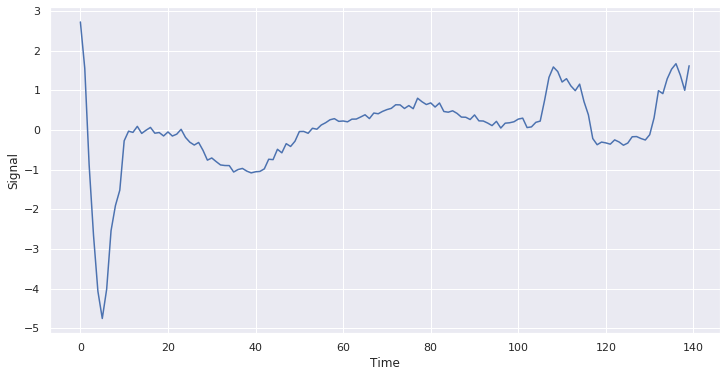

In [11]:
# let's see a random ECG sample (fragment)
INDEX = 1000

plot_ecg(data_vec, INDEX)

In [12]:
#  let's see how many distinct labels (categories)
numbers = data.groupby('label').count()

numbers['P1']

label
1    2627
2    1590
3      86
4     175
5      22
Name: P1, dtype: int64

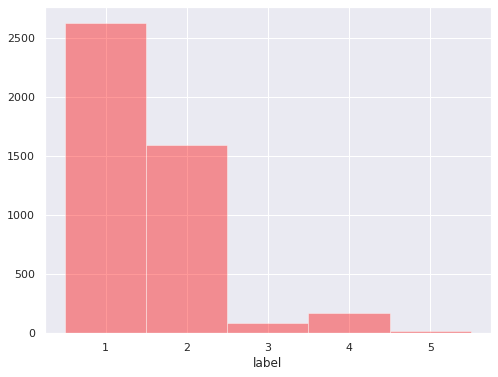

In [13]:
# here we have a nice hystogram. As usual most are OK fragments (label = 1)
# others are anomalous

bins = np.array([0])

bins = np.append(bins, data['label'].unique())

bins = bins + 0.5

plt.figure(figsize = (8,6))
sns.distplot(data['label'], bins = bins, kde= False, color = 'red');

In [14]:
# prepare data for training

# for AutoEncoder training let's take only NORMAL (label = 1) fragments
condition = (data['label'] == 1)

# we use only data_normal for training the Encoder
data_normal = data[condition]

X = np.array(data_normal)

# drop first column (label)
X = X[:, 1:]

In [15]:
# scale the values
X_scaled = scale_ecg(X)

In [16]:
X_scaled.shape

(2627, 140)

Label is: 0


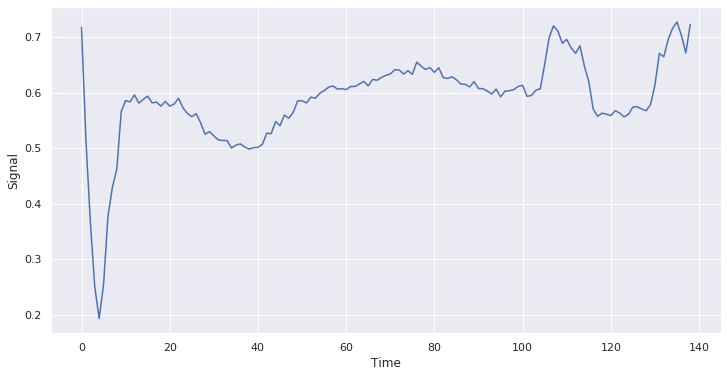

In [45]:
plot_ecg(X_scaled, 1000)

In [18]:
# here we define AutoEncoder architecture

def build_model(input_num):
    N1 = 64
    N2 = 32
    N3 = 16
    # from Chollet blog (check for improving!)
    my_reg = keras.regularizers.l1(10e-6)

    # con elu it is worse
    my_act = "relu"

    # Input layer:
    model = Sequential()

    # First hidden layer, connected to input vector X. 
    model.add(Dense(N1, activation = my_act, input_shape=(input_num,), 
                # suggested from Chollet Blog on Autoencoders
                activity_regularizer = my_reg 
               )
         )
    model.add(Dense(N2,activation = my_act, activity_regularizer = my_reg))
    model.add(Dense(N3,activation = my_act, activity_regularizer = my_reg))
    model.add(Dense(N2, activation = my_act))
    model.add(Dense(N1, activation = my_act))
    model.add(Dense(input_num))

    model.compile(loss='mse', optimizer='adam')
    
    return model

In [19]:
# define the NN

# the autoencoder is made by two part:
# 1. encoder
# 2. decoder

# NN is trained to reconstruct the input and the goal is to have a reconstruction error small as possible

seed(1234)
tf.random.set_seed(1234)

# number of data point in every fragment
input_num = 140

model = build_model(input_num)

In [20]:
# as we can see the network has input = 140, output = 140 !!!
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                9024      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 140)               9100      
Total params: 23,388
Trainable params: 23,388
Non-trainable params: 0
____________________________________________________

In [21]:
# Train the model

NUM_EPOCHS = 2500
BATCH_SIZE = 128
VAL_SPLIT = 0.1
NO_VERBOSE = 0

import time

t_start = time.time()

# y = X
history = model.fit(X_scaled, X_scaled, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, 
                           validation_split = VAL_SPLIT, verbose = 0)

# compute the training time
t_ela = time.time() - t_start

In [22]:
print('Training time (sec): ', round(t_ela, 1))

Training time (sec):  167.8


In [23]:
# dataset is not so big, NN is not so big, therefore you can train also on a modern laptop, in 10 mns.
# cool!

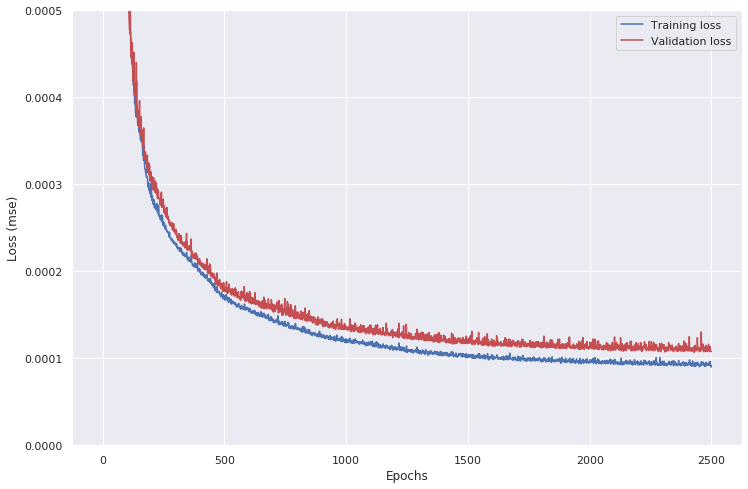

In [24]:
# visualize loss for the training
plt.figure(figsize = (12,8))
hist_loss = history.history['loss']
hist_val_loss = history.history['val_loss']

plt.plot(hist_loss,'b', label='Training loss')
plt.plot(hist_val_loss,'r', label='Validation loss')

plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss (mse)')
plt.ylim([0, 0.0005])

plt.show()

(0.0, 0.03)

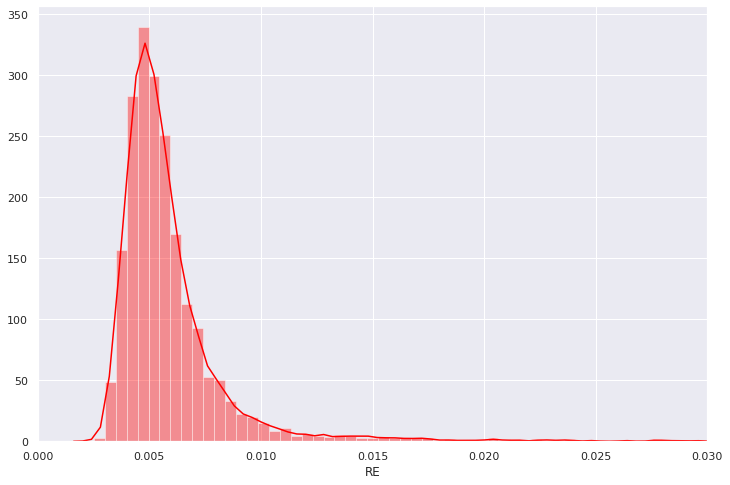

In [25]:
# prediction on train 
# RE: reconstruction error, calculated as MAE

# the network must reconstruct the input... therefore predict values should be as close as possible to input
X_pred = model.predict(X_scaled)

scored = pd.DataFrame()

# for every point compute the Reconstruction Error (RE) as Maximum Absolute Error (MAE)
scored['RE'] = np.mean(np.abs(X_pred - X_scaled), axis = 1)

# histogram
plt.figure(figsize = (12,8))
sns.distplot(scored['RE'], bins = 100, kde= True, color = 'red');

plt.xlim([0.0,0.03])

In [444]:
# from the plot we can see that for every sample the RE is almost every time less than 0.0205
# (it is an hyper-parameter of the model)
THRESHOLD = 0.0205

count = sum(scored['RE'] < THRESHOLD)

print('Percentage of normal samples below the threshold: ', round(count*100./len(X_scaled), 2))

Percentage of normal samples below the threshold:  99.24


In [406]:
# we have trained only on normal ECG fragment. Let's see if we work on all the samples in the test set (the TRAIN from the site) (normal + anomalous)
# using the hold out ECG5000_TEST_NEW test set

FILE_NAME_TEST = "ECG5000_TEST_NEW.txt"

data_test = pd.read_csv(FILE_NAME_TEST, delim_whitespace = True, header=None, engine = 'python')

data_test.columns = columns
data_test['label'] = data_test['label'].astype('int32')

In [407]:
# useful to save (see below)
X_test_old = np.array(data_test)
X_test = np.array(data_test)

# remove first column (label)
X_test = X_test[:, 1:]

In [408]:
# rememeber that we need to scale before inputting to the NN
X_test_scaled = scale_ecg(X_test)

(0.0, 0.1)

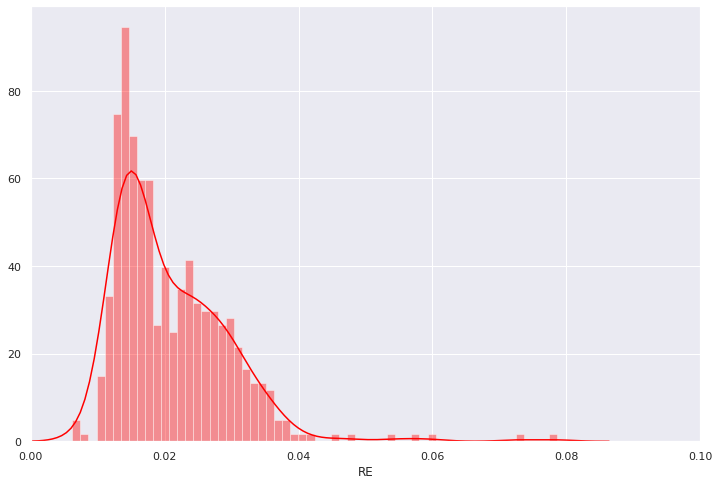

In [409]:
# compute prediction on TEST
X_pred_test = model.predict(X_test_scaled)

# collect data in DataFrame scored_test
scored_test = pd.DataFrame()

# for every point compute the reconstruction error as MAE
scored_test['RE'] = np.mean(np.abs(X_pred_test - X_test_scaled), axis = 1)

# add the label
scored_test['label'] = X_test_old[:, 0]
# register as anomalous if label gt 1 (this is the ground truth)

scored_test['Anomaly_reg'] = False
scored_test['Anomaly_reg'] = (scored_test['label'] > 1)
# register the prediction from the model with THRESHOLD
scored_test['Anomaly_pred'] = scored_test['RE'] > THRESHOLD

# histogram of the RE
plt.figure(figsize = (12,8))

# histogram
sns.distplot(scored_test['RE'], bins = 60, kde = True, color = 'red');

plt.xlim([0.0,0.1])

# be careful, the xlimit in this second plot is higher than in the previous one
# here we have a set of samples with RE > THRESHOLD.
# could we call those anomalous?

In [410]:
# if we compare the two hist, we see that in the TEST set (with normal + anomalous) we have a wider RE distribution, due to anomalous samples !!

In [411]:
# let's compute accuracy if we take every sample with RE > THRESHOLDS as anomalous
acc_condition = (scored_test['Anomaly_reg'] == scored_test['Anomaly_pred'])

accuracy = sum(acc_condition)/X_test.shape[0]

print("Accuracy on TEST set is: %.3f" %(accuracy))

Accuracy on TEST set is: 0.934


In [412]:
# check: TEST set has the same distribution than TRAIN set?

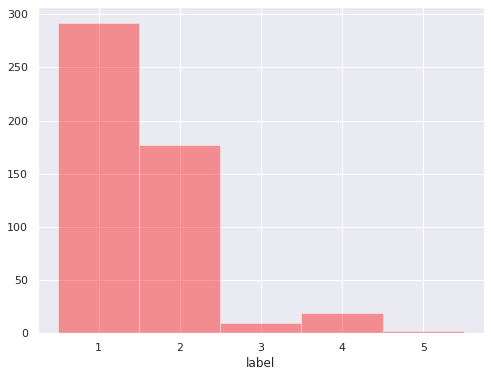

In [413]:
# have a look at distribution in TEST set

# two lines to have bar centered around labels (1,2...). That's why adding 0.5
bins = np.array([0])
bins = np.append(bins, data_test['label'].unique()) + 0.5

plt.figure(figsize = (8,6))
sns.distplot(data_test['label'], bins = bins, kde= False, color = 'red');

In [414]:
# Ok, TRAIN and TEST have the same distribution !

In [415]:
# now we should calculate TP, FP, TN, FN
# Sensitivity and Specificity for the test

# accuracy is not the only relevant metric

In [416]:
tp_condition = ((scored_test['Anomaly_reg'] == scored_test['Anomaly_pred']) & (scored_test['Anomaly_reg']))
tn_condition = ((scored_test['Anomaly_reg'] == scored_test['Anomaly_pred']) & (scored_test['Anomaly_reg'] == False))
fp_condition = ((scored_test['Anomaly_reg'] != scored_test['Anomaly_pred']) & (scored_test['Anomaly_reg'] == False))

In [417]:
TOTAL = data_test.shape[0]

TP = sum(tp_condition)
TN = sum(tn_condition)
FP = sum(fp_condition)
FN = TOTAL - (TP+TN+FP)

print('Total samples: ', TOTAL)
print(FP+FN, 'are incorrectly classified')
print('TP: ',TP)
print('TN: ',TN)
print('FP: ',FP)
print('FN: ', FN)

Total samples:  500
33 are incorrectly classified
TP:  195
TN:  272
FP:  20
FN:  13


In [418]:
# sensitivity in used in healthcare. It is also called Recall
sensitivity = float(TP)/(TP + FN)
specificity = float(TN)/(FP + TN)

# it is P(+|disease), the conditioned probability that an anomalous (disease) sample is correctly identified 
print('Sensitivity is: ', round(sensitivity, 3))
# it is P(-|normal) the conditioned probability that an anomalous normal sample is correctly identified 
print('Specificity is: ', round(specificity, 3))

Sensitivity is:  0.938
Specificity is:  0.932


In [333]:
# OK, we have 0.93 accuracy, but Sensitivity is higher. Our model is slightly better at identifing anomalous case than normal case
# using a careful choice of the THRESHOLD

# FN are slightly more than 2%

# to improve
# work on hyper-parameters (#of neurons for layer, THRESHOLD, ...)
# add more sample
# we could lower the THRESHOLD (but it will increase FP, it's a tradeoff)

In [419]:
# you could test what happen if you lower the THRESHOLD

In [420]:
# another test: let's take a "normal" and an anomalous fragment and compare with the reconstruction done by the AutoEncoder

In [421]:
data_test_normal = data_test[data_test['label'] == 1]
data_test_anomal = data_test[data_test['label'] > 1]

X_test_normal = np.array(data_test_normal)

# remove first column (label)
X_test_normal = X_test_normal[:, 1:]

X_test_anomal = np.array(data_test_anomal)

# remove first column (label)
X_test_anomal = X_test_anomal[:, 1:]

# be careful when scaling here, cannot use func
# if we use scale_ecg... eveything goes wrong
min = X_test.min()
max = X_test.max()

X_test_normal_scaled = (X_test_normal - min)/(max - min)
X_test_anomal_scaled = (X_test_anomal - min)/(max - min)

In [422]:
# let's apply the Autoencoder

X_test_normal_predicted = model.predict(X_test_normal_scaled)
X_test_anomal_predicted = model.predict(X_test_anomal_scaled)

0.006214697017884995
0.05375212776942575
20
292


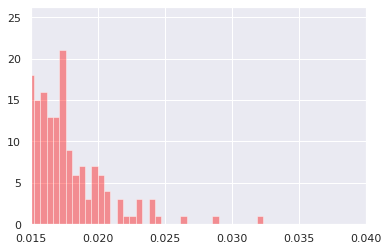

In [423]:
# compare side by side

# normal

INDEX = np.random.randint(0, high=len(X_test_normal_scaled))

vet = X_test_normal_scaled
pred = X_test_normal_predicted

MAE = np.mean(np.abs(vet - pred), axis = 1)

sns.distplot(MAE, bins = 100, kde= False, color = 'red');

plt.xlim([0.015,0.04])

print(np.min(MAE))
print(np.max(MAE))

# FP
print(sum(MAE > THRESHOLD))
print(len(X_test_normal_scaled))

0.01451893115829675
0.07855373192746658
13


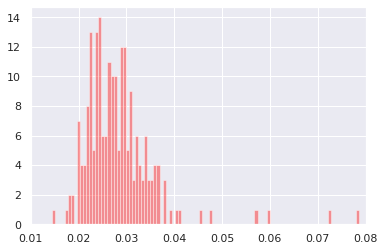

In [424]:
# anomal
INDEX = np.random.randint(0, high=len(X_test_anomal_scaled))

vet = X_test_anomal_scaled
pred = X_test_anomal_predicted

MAE = np.mean(np.abs(vet - pred), axis = 1)

sns.distplot(MAE, bins = 100, kde= False, color = 'red');

plt.xlim([0.01,0.08])

print(np.min(MAE))
print(np.max(MAE))

# FN
ltTH = sum(MAE < THRESHOLD)

print(ltTH)

In [354]:
# visually we could see the difference, the AutoEncoders knows how to rebuild normal, it is less effective in rebuilding anormal

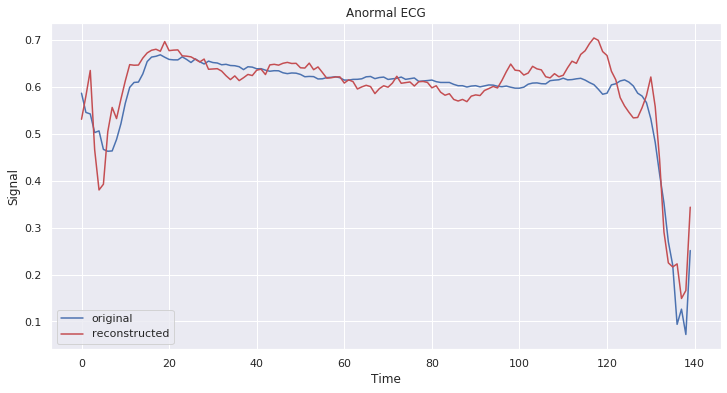

MAE is:  0.02918396385573396


In [439]:
# do some plot

# anomal

INDEX = np.random.randint(0, high=len(X_test_anomal_scaled))


vet = X_test_anomal_scaled[INDEX]
pred = X_test_anomal_predicted[INDEX]
time = np.arange(len(vet))

plt.figure(figsize = (12,6))

plt.title('Anormal ECG')
plt.plot(time, vet, 'b')
plt.plot(time, pred, 'r')

plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend(['original','reconstructed'])

plt.show()

MAE = np.mean(np.abs(vet - pred))
print('MAE is: ', MAE)

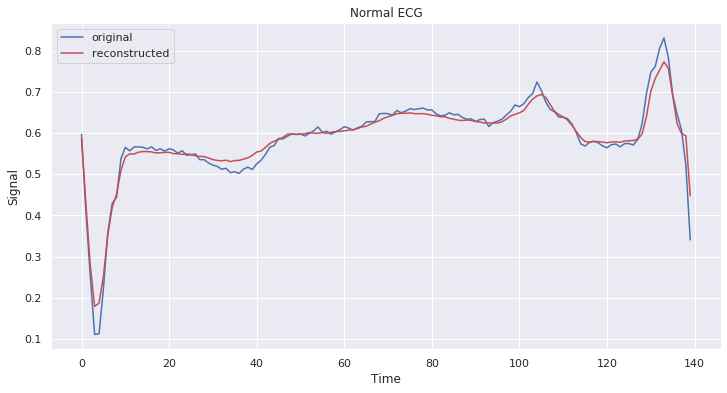

MAE is:  0.013417723377526058


In [440]:
INDEX = np.random.randint(0, high=len(X_test_normal_scaled))

time = np.arange(len(vet))
vet = X_test_normal_scaled[INDEX]
pred = X_test_normal_predicted[INDEX]

plt.figure(figsize = (12,6))

plt.title('Normal ECG')
plt.plot(time, vet, 'b')
plt.plot(time, pred, 'r')

plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend(['original','reconstructed'])
    
plt.show()

MAE = np.mean(np.abs(vet - pred))
print('MAE is: ', MAE)